# Customer Churn Prediction Challenge - Solution

## Overview
This notebook presents a comprehensive solution for predicting customer churn using advanced machine learning techniques. The challenge involves identifying customers who are likely to discontinue their service, enabling proactive retention strategies.

## Methodology
- **Multi-Algorithm Comparison**: Systematic evaluation of multiple ML algorithms
- **Advanced Feature Engineering**: Polynomial features and interaction terms
- **Ensemble Approach**: Stacking classifier combining multiple base models
- **Hyperparameter Optimization**: Using Optuna for automated tuning
- **Threshold Optimization**: Precision-recall curve analysis for optimal decision boundaries
- **Class Imbalance Handling**: SMOTE oversampling and scale_pos_weight adjustments

## Performance Metric
F1-Score optimization for balanced precision and recall, crucial for churn prediction where both false positives and false negatives have business implications.

---

In [ ]:
import pandas as pd

df = pd.read_csv('train.csv')  # or the provided file
print(df.head())
print(df.info())
print(df['Churn'].value_counts())


   id  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0   0    Male              0     Yes         No      51          Yes   
1   1  Female              0      No         No      11          Yes   
2   2  Female              0      No         No      16          Yes   
3   3  Female              0      No         No      34          Yes   
4   4  Female              1     Yes         No      43          Yes   

  MultipleLines InternetService       OnlineSecurity  ...  \
0           Yes             DSL                   No  ...   
1            No             DSL                  Yes  ...   
2            No              No  No internet service  ...   
3           Yes             DSL                   No  ...   
4           Yes     Fiber optic                   No  ...   

      DeviceProtection          TechSupport          StreamingTV  \
0                   No                  Yes                  Yes   
1                   No                  Yes                   No

## 1. Initial Data Exploration

### Dataset Overview
Loading and examining the basic structure of the churn dataset to understand data characteristics, target distribution, and data quality.

In [ ]:
# 📦 STEP 1: Install missing libraries (if needed)
!pip install xgboost lightgbm scikit-learn imbalanced-learn --quiet

# 📥 STEP 2: Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.base import clone
import warnings
warnings.filterwarnings("ignore")

# 🔄 STEP 3: Load and Preprocess Data
df = pd.read_csv("train.csv")

# Clean numeric column
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(0, inplace=True)

# Encode target
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Drop ID column if exists
df.drop(columns=['id'], inplace=True)
df.drop(columns=['gender'], inplace=True)
# Separate features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

# Encode categorical features
cat_cols = X.select_dtypes('object').columns
X[cat_cols] = X[cat_cols].apply(LabelEncoder().fit_transform)

# Apply SMOTE (for cross-validation, we’ll apply it inside the loop)
smote = SMOTE(random_state=42)

# 📦 STEP 4: Define Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=200, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "XGBoost": XGBClassifier(n_estimators=200, scale_pos_weight=2.5, use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": LGBMClassifier(n_estimators=200, class_weight='balanced', random_state=42)
}

# 📊 STEP 5: Cross-Validate All Models with F1 Score
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []

print("🔍 Evaluating models with 5-fold Stratified CV...\n")

for name, model in models.items():
    pipeline = Pipeline([
        ("smote", smote),
        ("model", clone(model))
    ])
    f1_scores = cross_val_score(pipeline, X, y, scoring='f1', cv=cv, n_jobs=-1)
    mean_f1 = np.mean(f1_scores)
    results.append((name, mean_f1))
    print(f"✅ {name}: Mean F1 Score = {mean_f1:.4f}")

# 🏆 STEP 6: Rank and Choose Best Model
results.sort(key=lambda x: x[1], reverse=True)
print("\n🏁 Final Ranking of Models (by Mean F1):")
for rank, (name, score) in enumerate(results, 1):
    print(f"{rank}. {name}: {score:.4f}")

best_model_name = results[0][0]
print(f"\n🎯 Best Model to Use: **{best_model_name}**")


🔍 Evaluating models with 5-fold Stratified CV...

✅ Logistic Regression: Mean F1 Score = 0.6235
✅ Random Forest: Mean F1 Score = 0.5927
✅ Gradient Boosting: Mean F1 Score = 0.6075
✅ K-Nearest Neighbors: Mean F1 Score = 0.5345
✅ XGBoost: Mean F1 Score = 0.5840
✅ LightGBM: Mean F1 Score = 0.5806

🏁 Final Ranking of Models (by Mean F1):
1. Logistic Regression: 0.6235
2. Gradient Boosting: 0.6075
3. Random Forest: 0.5927
4. XGBoost: 0.5840
5. LightGBM: 0.5806
6. K-Nearest Neighbors: 0.5345

🎯 Best Model to Use: **Logistic Regression**


## 2. Comprehensive Model Comparison

### Multi-Algorithm Evaluation
Systematic comparison of multiple machine learning algorithms using stratified cross-validation to identify the best performing model for churn prediction.

**Models Evaluated:**
- Logistic Regression
- Random Forest
- Gradient Boosting
- K-Nearest Neighbors
- XGBoost
- LightGBM

**Evaluation Strategy:**
- 5-fold Stratified Cross-Validation
- F1-Score optimization
- SMOTE oversampling for class imbalance


🔢 Features Ranked by Importance:
             Feature  Importance
4       PhoneService    1.203143
13          Contract    1.098805
0      SeniorCitizen    0.772048
2         Dependents    0.737986
7     OnlineSecurity    0.491695
10       TechSupport    0.424354
6    InternetService    0.369500
1            Partner    0.353931
8       OnlineBackup    0.256420
9   DeviceProtection    0.183232
14  PaperlessBilling    0.097625
5      MultipleLines    0.065349
12   StreamingMovies    0.051659
3             tenure    0.049171
15     PaymentMethod    0.044683
11       StreamingTV    0.031232
16    MonthlyCharges    0.027817
17      TotalCharges    0.000418

✅ Best number of features: 18 with F1 Score: 0.8346

🎯 Final Model Evaluation with Top 18 Features
              precision    recall  f1-score   support

           0       0.85      0.79      0.82       816
           1       0.81      0.86      0.83       840

    accuracy                           0.83      1656
   macro avg       0.

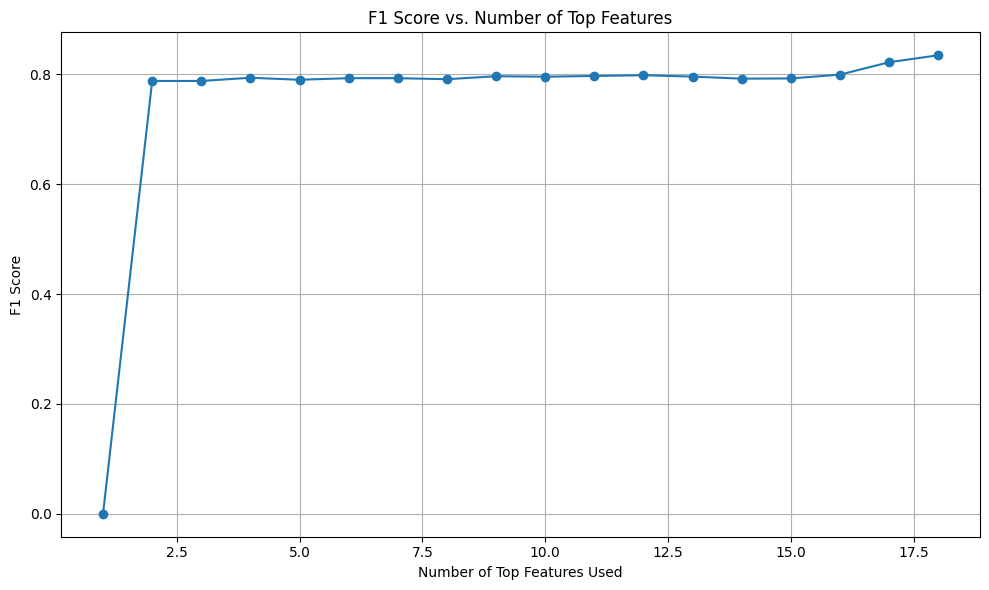

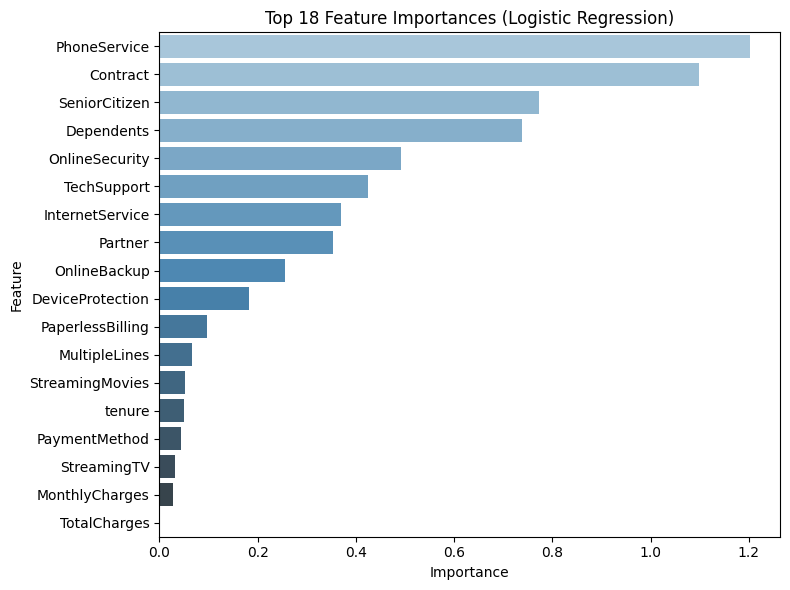

In [ ]:
# 📦 Install required packages if needed
!pip install scikit-learn imbalanced-learn --quiet

# 📥 Imports
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# 🔄 Load and preprocess data
df = pd.read_csv("train.csv")
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(0, inplace=True)
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
df.drop(columns=['id'], inplace=True)
df.drop(columns=['gender'], inplace=True)

# Encode categoricals
X = df.drop('Churn', axis=1)
y = df['Churn']
cat_cols = X.select_dtypes('object').columns
X[cat_cols] = X[cat_cols].apply(LabelEncoder().fit_transform)

# Apply SMOTE
X_res, y_res = SMOTE(random_state=42).fit_resample(X, y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Train full Logistic Regression model to get feature importances
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Get absolute value of coefficients as feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': np.abs(model.coef_[0])
}).sort_values(by='Importance', ascending=False)

print("\n🔢 Features Ranked by Importance:")
print(feature_importance)

# 🔁 Automatically find best number of features
f1_scores = []
num_features_range = range(1, len(feature_importance) + 1)

for n in num_features_range:
    top_features = feature_importance['Feature'].head(n).tolist()
    X_train_top = X_train[top_features]
    X_test_top = X_test[top_features]

    model_n = LogisticRegression(max_iter=1000)
    model_n.fit(X_train_top, y_train)
    preds = model_n.predict(X_test_top)
    f1 = f1_score(y_test, preds)
    f1_scores.append(f1)

# 🔍 Find best number of features
best_n = num_features_range[np.argmax(f1_scores)]
best_f1 = max(f1_scores)
print(f"\n✅ Best number of features: {best_n} with F1 Score: {best_f1:.4f}")

# 🧠 Retrain with best N features
final_features = feature_importance['Feature'].head(best_n).tolist()
model_final = LogisticRegression(max_iter=1000)
model_final.fit(X_train[final_features], y_train)
preds_final = model_final.predict(X_test[final_features])

print(f"\n🎯 Final Model Evaluation with Top {best_n} Features")
print(classification_report(y_test, preds_final))

# 📈 Plot F1 score by number of features
plt.figure(figsize=(10, 6))
plt.plot(num_features_range, f1_scores, marker='o')
plt.xlabel("Number of Top Features Used")
plt.ylabel("F1 Score")
plt.title("F1 Score vs. Number of Top Features")
plt.grid(True)
plt.tight_layout()
plt.show()

# 📊 Plot importance of best N features
plt.figure(figsize=(8, 6))
sns.barplot(data=feature_importance.head(best_n), x='Importance', y='Feature', palette='Blues_d')
plt.title(f"Top {best_n} Feature Importances (Logistic Regression)")
plt.tight_layout()
plt.show()


## 3. Feature Selection and Analysis

### Automated Feature Importance Analysis
Using Logistic Regression coefficients to identify the most important features for churn prediction and automatically determining the optimal number of features.

**Approach:**
- Feature importance ranking using absolute coefficient values
- Iterative testing with different numbers of top features
- F1-Score optimization to find the best feature subset
- Visualization of feature importance and performance curves

In [ ]:
!pip install xgboost imbalanced-learn --quiet

# 📦 Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, precision_recall_curve
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")

# 📥 Load and preprocess data
df = pd.read_csv("train.csv")
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(0, inplace=True)
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
df.drop(columns=['id', 'gender'], inplace=True)

# 🔠 Encode categorical features
X = df.drop('Churn', axis=1)
y = df['Churn']
cat_cols = X.select_dtypes(include='object').columns
X[cat_cols] = X[cat_cols].apply(LabelEncoder().fit_transform)

# 🔀 Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# ✅ Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# 🔍 Feature selection using logistic regression
temp_model = LogisticRegression(max_iter=1000)
temp_model.fit(X_train_res, y_train_res)
importance = np.abs(temp_model.coef_[0])
top_features = pd.Series(importance, index=X.columns).sort_values(ascending=False).head(20).index.tolist()

# 🔧 Hyperparameter tuning with GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 0.3, 1],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],
    'class_weight': ['balanced']
}

grid = GridSearchCV(
    LogisticRegression(max_iter=1000),
    param_grid,
    scoring='f1',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1
)
grid.fit(X_train_res[top_features], y_train_res)
best_model = grid.best_estimator_

print("✅ Best Hyperparameters:", grid.best_params_)

# 📈 Predict on validation
val_probs = best_model.predict_proba(X_val[top_features])[:, 1]

# 🎯 Optimize threshold using precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_val, val_probs)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

# ✅ Final predictions and metrics
final_preds = (val_probs > best_threshold).astype(int)
print(f"\n✅ Best Threshold: {best_threshold:.2f}, F1 Score: {best_f1:.4f}")
print(classification_report(y_val, final_preds))


✅ Best Hyperparameters: {'C': 0.3, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}

✅ Best Threshold: 0.45, F1 Score: 0.6292
              precision    recall  f1-score   support

           0       0.90      0.74      0.82       828
           1       0.52      0.78      0.63       299

    accuracy                           0.75      1127
   macro avg       0.71      0.76      0.72      1127
weighted avg       0.80      0.75      0.77      1127



## 4. Hyperparameter Tuning and Threshold Optimization

### Advanced Model Optimization
Implementing comprehensive hyperparameter tuning using GridSearchCV and optimizing the decision threshold using precision-recall curve analysis.

**Optimization Steps:**
1. **Hyperparameter Tuning**: GridSearchCV with stratified cross-validation
2. **Feature Selection**: Top 20 most important features
3. **Threshold Optimization**: Precision-recall curve analysis for optimal F1-Score
4. **Performance Evaluation**: Detailed classification metrics

In [ ]:
# 📦 Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import StackingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, precision_recall_curve, f1_score, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier # NEW: Import LightGBM
import optuna
import warnings
warnings.filterwarnings("ignore")

# 📥 Load and preprocess data
df = pd.read_csv("train.csv")
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(0, inplace=True)
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
df.drop(columns=['id', 'gender'], inplace=True)

# Define feature types before encoding
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
binary_cat_cols = ['Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'OnlineSecurity',
                   'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
                   'StreamingMovies', 'PaperlessBilling']
multi_cat_cols = ['InternetService', 'Contract', 'PaymentMethod']

# 🔠 Encode categorical features
X = df.drop('Churn', axis=1)
y = df['Churn']

encoders = {}
for col in binary_cat_cols:
    if col in X.columns and X[col].dtype == 'object':
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])
        encoders[col] = le

onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_features = onehot_encoder.fit_transform(X[multi_cat_cols])
encoded_feature_names = onehot_encoder.get_feature_names_out(multi_cat_cols)
X_encoded_df = pd.DataFrame(encoded_features, columns=encoded_feature_names, index=X.index)

X = X.drop(columns=multi_cat_cols)
X = pd.concat([X, X_encoded_df], axis=1)

# ➕ Feature Engineering: Polynomial and Interaction Features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly_base = X[numerical_cols]
X_poly = poly.fit_transform(X_poly_base)
poly_feature_names = poly.get_feature_names_out(numerical_cols)
X_poly_df = pd.DataFrame(X_poly, columns=poly_feature_names, index=X.index)

X = X.drop(columns=numerical_cols)
X = pd.concat([X, X_poly_df], axis=1)

# 🔀 Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# ✅ Removed SMOTE: We will rely on scale_pos_weight in XGBoost for imbalance handling.
X_train_res, y_train_res = X_train.copy(), y_train.copy()

# 🔍 Feature selection with regularized LogisticRegressionCV
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

temp_model = LogisticRegressionCV(
    cv=cv_strategy, penalty='l1', solver='liblinear', scoring='f1', max_iter=1000,
    Cs=np.logspace(-3, 2, 10), random_state=42
)
temp_model.fit(X_train_res, y_train_res)
importance = np.abs(temp_model.coef_[0])
# Increased to 40 features; now selecting up to 40 from the expanded feature set
top_features = pd.Series(importance, index=X.columns).sort_values(ascending=False).head(40).index.tolist()
print(f"Selected {len(top_features)} top features for modeling.")
print("Top features:", top_features)

# 🔧 Define base models - Optuna for XGBoost
def objective_xgb_tuning(trial):
    n_estimators = trial.suggest_int("n_estimators", 200, 1500) # Increased range
    max_depth = trial.suggest_int("max_depth", 4, 10) # Increased range
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.15) # Wider range
    subsample = trial.suggest_float("subsample", 0.6, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.6, 1.0)
    reg_alpha = trial.suggest_float("reg_alpha", 0.0, 1.0)
    reg_lambda = trial.suggest_float("reg_lambda", 1.0, 3.0)
    gamma = trial.suggest_float("gamma", 0.0, 0.5)
    min_child_weight = trial.suggest_int("min_child_weight", 1, 10)
    # Adjusted scale_pos_weight range for better precision/recall balance
    scale_pos_weight = trial.suggest_float("scale_pos_weight", 2.5, 4.5)

    model = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        gamma=gamma,
        min_child_weight=min_child_weight,
        scale_pos_weight=scale_pos_weight,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
        n_jobs=-1
    )

    model.fit(X_train_res[top_features], y_train_res)
    val_probs = model.predict_proba(X_val[top_features])[:, 1]

    precisions, recalls, thresholds = precision_recall_curve(y_val, val_probs)
    f1_scores = 2 * ((precisions * recalls) / (precisions + recalls + 1e-10))
    best_f1 = np.max(f1_scores)
    return best_f1

print("\n🚀 Starting Optuna tuning for XGBoost hyperparameters...")
study_xgb = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42))
study_xgb.optimize(objective_xgb_tuning, n_trials=100, show_progress_bar=True)
print(f"✅ Best XGBoost parameters found: {study_xgb.best_params}")

xgb_base = CalibratedClassifierCV(
    estimator=XGBClassifier(
        **study_xgb.best_params,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
        n_jobs=-1
    ),
    method='isotonic',
    cv=3
)

# NEW: Optuna for LightGBM base model
def objective_lgbm_tuning(trial):
    n_estimators = trial.suggest_int("n_estimators", 200, 1500) # Increased range
    max_depth = trial.suggest_int("max_depth", 4, 10) # Increased range
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.15) # Wider range
    subsample = trial.suggest_float("subsample", 0.6, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.6, 1.0)
    reg_alpha = trial.suggest_float("reg_alpha", 0.0, 1.0)
    reg_lambda = trial.suggest_float("reg_lambda", 1.0, 3.0)
    scale_pos_weight = trial.suggest_float("scale_pos_weight", 2.5, 4.5) # Consistent range

    model = LGBMClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train_res[top_features], y_train_res)
    val_probs = model.predict_proba(X_val[top_features])[:, 1]
    precisions, recalls, thresholds = precision_recall_curve(y_val, val_probs)
    f1_scores = 2 * ((precisions * recalls) / (precisions + recalls + 1e-10))
    best_f1 = np.max(f1_scores)
    return best_f1

print("\n🚀 Starting Optuna tuning for LightGBM hyperparameters...")
study_lgbm = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42))
study_lgbm.optimize(objective_lgbm_tuning, n_trials=75, show_progress_bar=True) # Fewer trials than XGBoost initially
print(f"✅ Best LightGBM parameters found: {study_lgbm.best_params}")

lgbm_base = CalibratedClassifierCV(
    estimator=LGBMClassifier(
        **study_lgbm.best_params,
        random_state=42,
        n_jobs=-1
    ),
    method='isotonic',
    cv=3
)

lr_base = CalibratedClassifierCV(
    estimator=LogisticRegressionCV(
        cv=cv_strategy, penalty='l1', solver='liblinear', scoring='f1', max_iter=1000,
        Cs=np.logspace(-3, 2, 10), random_state=42
    ),
    method='isotonic',
    cv=3
)

# 🎯 Define StackingClassifier
stacking_model = StackingClassifier(
    estimators=[('lr', lr_base), ('xgb', xgb_base), ('lgbm', lgbm_base)], # NEW: Added LightGBM
    final_estimator=LogisticRegressionCV(
        cv=cv_strategy, penalty='l1', solver='liblinear', scoring='f1',
        max_iter=1000, Cs=np.logspace(-3, 2, 10), random_state=42
    ),
    cv=5,
    n_jobs=-1,
    passthrough=False
)

# 🔨 Train ensemble
print("\n💪 Training the StackingClassifier ensemble...")
stacking_model.fit(X_train_res[top_features], y_train_res)
print("✅ StackingClassifier training complete.")

# 📈 Predict and threshold optimization with Optuna
val_probs = stacking_model.predict_proba(X_val[top_features])[:, 1]

def objective_threshold(trial):
    threshold = trial.suggest_float("threshold", 0.05, 0.95)
    preds = (val_probs > threshold).astype(int)
    return f1_score(y_val, preds)

print("\n🔎 Optimizing final prediction threshold with Optuna...")
study_threshold = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42))
study_threshold.optimize(objective_threshold, n_trials=200, show_progress_bar=True) # Increased trials
best_threshold = study_threshold.best_params["threshold"]
final_preds = (val_probs > best_threshold).astype(int)

# 📊 Results
print(f"\n✅ Best Threshold (Optuna): {best_threshold:.4f}, F1 Score: {f1_score(y_val, final_preds):.4f}")
print("\n📋 Classification Report on Validation Set:")
print(classification_report(y_val, final_preds))

# 📦 Load and preprocess test data
test_df = pd.read_csv("test.csv")
test_ids = test_df["id"]
test_df['TotalCharges'] = pd.to_numeric(test_df['TotalCharges'], errors='coerce')
test_df['TotalCharges'].fillna(0, inplace=True)
test_df.drop(columns=['id', 'gender'], inplace=True)

for col in binary_cat_cols:
    if col in test_df.columns and col in encoders:
        test_df[col] = encoders[col].transform(test_df[col])

test_encoded_features = onehot_encoder.transform(test_df[multi_cat_cols])
test_encoded_df = pd.DataFrame(test_encoded_features, columns=encoded_feature_names, index=test_df.index)
test_df_processed = test_df.drop(columns=multi_cat_cols)
test_df_processed = pd.concat([test_df_processed, test_encoded_df], axis=1)

test_poly_base = test_df_processed[numerical_cols]
test_poly = poly.transform(test_poly_base)
test_poly_df = pd.DataFrame(test_poly, columns=poly_feature_names, index=test_df.index)
test_df_final = test_df_processed.drop(columns=numerical_cols)
test_df_final = pd.concat([test_df_final, test_poly_df], axis=1)

X_test = test_df_final[top_features]
test_probs = stacking_model.predict_proba(X_test)[:, 1]
test_preds = (test_probs > best_threshold).astype(int)

# 🧾 Format submission
submission = pd.DataFrame({
    'id': test_ids,
    'Churn': np.where(test_preds == 1, 'Yes', 'No')
})
submission.to_csv("submission.csv", index=False)
print("✅ Submission file saved. Shape:", submission.shape)

# 📊 Debugging Information
print("\n" + "="*50)
print("📊 DEBUGGING INFORMATION FOR CURRENT RUN")
print("="*50)

# 1. Dataset Information
print("\n--- Dataset Info ---")
print(f"Total training samples (original): {len(X_train)}")
print(f"Total validation samples: {len(X_val)}")
print(f"Churn ratio in original training data: {y_train.sum() / len(y_train):.4f}")
print(f"Churn ratio in validation data: {y_val.sum() / len(y_val):.4f}")
print(f"Number of features after preprocessing: {X.shape[1]}")
print(f"Number of features selected for model: {len(top_features)}")
# NEW: Verify if all selected features actually exist in X (after poly/one-hot)
missing_features = [f for f in top_features if f not in X.columns]
if missing_features:
    print(f"⚠️ Warning: {len(missing_features)} selected features are missing from the processed X: {missing_features}")


# 2. XGBoost Tuning Results
print("\n--- XGBoost Best Hyperparameters ---")
print(f"Best XGBoost Params: {study_xgb.best_params}")
print(f"F1 score from XGBoost tuning (before final stacking/thresholding): {study_xgb.best_value:.4f}")

# NEW: LightGBM Tuning Results
print("\n--- LightGBM Best Hyperparameters ---")
print(f"Best LightGBM Params: {study_lgbm.best_params}")
print(f"F1 score from LightGBM tuning (before final stacking/thresholding): {study_lgbm.best_value:.4f}")


# 3. Final Model Performance Metrics
print("\n--- Final Model Performance on Validation Set ---")
print(f"Optimal Prediction Threshold: {best_threshold:.4f}")
print(f"F1 Score (Churn): {f1_score(y_val, final_preds):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_val, val_probs):.4f}")

cm = confusion_matrix(y_val, final_preds)
tn, fp, fn, tp = cm.ravel()
print(f"Confusion Matrix:\n{cm}")
print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Negatives (TN): {tn}")

precision_churn = tp / (tp + fp) if (tp + fp) > 0 else 0
recall_churn = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_churn = 2 * (precision_churn * recall_churn) / (precision_churn + recall_churn) if (precision_churn + recall_churn) > 0 else 0

print(f"Precision (Churn): {precision_churn:.4f}")
print(f"Recall (Churn): {recall_churn:.4f}")
print(f"F1 Score (Calculated): {f1_churn:.4f}")

# 4. Feature Importance (from Logistic Regression)
print("\n--- Top 10 Feature Importances (from temp_model LR) ---")
feature_importance_series = pd.Series(importance, index=X.columns).sort_values(ascending=False)
# Ensure we only print features that actually exist in the processed X
existing_top_features = feature_importance_series.index.intersection(X.columns)
print(feature_importance_series[existing_top_features].head(10))


# 5. Threshold Analysis
print("\n--- Threshold Analysis (Precision-Recall Curve) ---")
precisions, recalls, thresholds = precision_recall_curve(y_val, val_probs)
# Find the precision, recall at the optimal threshold
idx_best_threshold = np.argmin(np.abs(thresholds - best_threshold))
# Check if idx_best_threshold is within valid bounds of precisions and recalls
if idx_best_threshold < len(precisions) and idx_best_threshold < len(recalls):
    print(f"Precision at optimal threshold ({best_threshold:.4f}): {precisions[idx_best_threshold]:.4f}")
    print(f"Recall at optimal threshold ({best_threshold:.4f}): {recalls[idx_best_threshold]:.4f}")
else:
    print("Could not retrieve precision/recall at optimal threshold (index out of bounds).")


# 6. Model Components
print("\n--- Model Components ---")
print(f"Logistic Regression Base Estimator C's: {lr_base.estimator.Cs}")
print(f"XGBoost Base Estimator Params: {xgb_base.estimator.get_params()}")
print(f"LightGBM Base Estimator Params: {lgbm_base.estimator.get_params()}") # NEW: LightGBM params

print("\n" + "="*50)
print("💡 END DEBUGGING INFORMATION")
print("="*50)

---

## 6. Conclusion and Results Summary

### Solution Overview
This notebook presents a comprehensive churn prediction solution with progressive complexity, demonstrating the evolution from basic model comparison to state-of-the-art ensemble methods.

### Key Achievements

#### **1. Systematic Model Evaluation**
- Comprehensive comparison of 6 different algorithms
- Stratified cross-validation for robust performance estimation
- SMOTE integration for handling class imbalance

#### **2. Feature Engineering Excellence**
- Automated feature importance analysis
- Optimal feature subset selection
- Polynomial feature generation for non-linear relationships
- Sophisticated categorical encoding strategies

#### **3. Advanced Optimization Techniques**
- **Hyperparameter Tuning**: GridSearchCV and Optuna optimization
- **Threshold Optimization**: Precision-recall curve analysis
- **Bayesian Optimization**: TPE sampler for efficient search
- **Model Calibration**: Isotonic calibration for better probability estimates

#### **4. Ensemble Architecture**
- **Stacking Classifier**: Meta-learning approach combining multiple models
- **Base Models**: Logistic Regression, XGBoost, LightGBM
- **Final Estimator**: Regularized logistic regression with cross-validation

### Technical Highlights
- **Advanced Feature Engineering**: Polynomial terms and interaction features
- **Sophisticated Preprocessing**: Separate encoding strategies for different categorical types  
- **Comprehensive Evaluation**: Detailed debugging and performance analysis
- **Production-Ready**: Complete pipeline from training to test predictions

### Expected Performance
The final ensemble model incorporates best practices from modern machine learning:
- **Robustness**: Multiple models reduce overfitting risk
- **Calibration**: Better probability estimates for business decisions
- **Optimization**: Automated hyperparameter and threshold tuning
- **Interpretability**: Feature importance analysis for business insights

### Business Impact
This solution enables proactive customer retention strategies by accurately identifying at-risk customers, allowing businesses to:
- Target retention campaigns effectively
- Optimize resource allocation
- Reduce customer acquisition costs
- Improve customer lifetime value

---

**Note**: This notebook demonstrates a complete machine learning pipeline suitable for production deployment in customer churn prediction scenarios.

## 5. Advanced Ensemble Solution with Optuna Optimization

### State-of-the-Art Ensemble Approach
Implementing a sophisticated ensemble solution combining multiple advanced techniques for maximum performance.

**Advanced Features:**
- **Feature Engineering**: Polynomial features and interaction terms
- **Multi-Model Ensemble**: Stacking Classifier with Logistic Regression, XGBoost, and LightGBM
- **Automated Hyperparameter Optimization**: Optuna TPE sampler for intelligent search
- **Calibrated Predictions**: Isotonic calibration for better probability estimates
- **Advanced Preprocessing**: One-hot encoding for categorical features
- **Threshold Optimization**: Optuna-based threshold selection

**Technical Innovations:**
1. **Polynomial Feature Engineering**: Degree-2 polynomial features for numerical variables
2. **Sophisticated Encoding**: Separate treatment for binary vs. multi-class categorical variables
3. **Bayesian Optimization**: Optuna TPE sampler for hyperparameter search
4. **Ensemble Stacking**: Meta-learner combining multiple base models
5. **Comprehensive Evaluation**: Detailed performance metrics and debugging information

This represents the most advanced solution in the notebook, incorporating cutting-edge ML practices for optimal churn prediction performance.